1/1 [==============================] - 0s 122ms/step
Similarity score: 1.0000001192092896


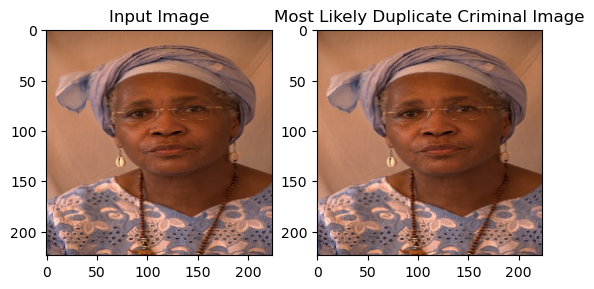

Time taken: 8.61512041091919 seconds


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import time
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to load image at path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return image

def extract_features(input_image, model):
    input_image = np.expand_dims(input_image, axis=0)
    features = model.predict(input_image)
    return features.flatten()

def build_siamese_network(input_shape):
    # Define the input layers for the two input images
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Define the base model (shared weights) for the Siamese network
    base_model = ResNet50(weights='imagenet', include_top=False)

    # Obtain the encoded representations of the two input images
    encoded_a = base_model(input_a)
    encoded_b = base_model(input_b)

    # Calculate the Euclidean distance between the two encoded representations
    distance = Lambda(lambda embeddings: tf.norm(embeddings[0] - embeddings[1], axis=-1), output_shape=(1,))([encoded_a, encoded_b])

    # Output layer
    output = Dense(1, activation='sigmoid')(distance)

    # Construct the Siamese model with two input branches and one output branch
    siamese_model = Model(inputs=[input_a, input_b], outputs=output)

    return siamese_model

# Load pre-trained ResNet50 model

base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)



criminal_image_path = 'D:/Cyber Department/criminal/criminal.jpg'
try:
    criminal_image = load_and_preprocess_image(criminal_image_path)
    criminal_features = extract_features(criminal_image, model)
except Exception as e:
    print(f"Error loading the criminal image: {e}")

directory1 = 'D:/Cyber Department/Find Criminal/Original J90262'
directory2 = 'D:/Cyber Department/Find Criminal/Twin J90263'
# Threshold for similarity score
threshold = 0.8
all_image_files = []
all_image_files.extend([os.path.join(directory1, f) for f in os.listdir(directory1) if f.endswith(('.jpg', '.jpeg', '.png'))])
all_image_files.extend([os.path.join(directory2, f) for f in os.listdir(directory2) if f.endswith(('.jpg', '.jpeg', '.png'))])

# Variables to store most likely criminal image and similarity score
start_time = time.time()
max_similarity_score = 0
most_likely_criminal_image = None
correct_matches = 0

# Loop through all images in the directories
for image_file in all_image_files:
    dataset_image = load_and_preprocess_image(image_file)
    dataset_features = extract_features(dataset_image, model)
    similarity_score = np.dot(criminal_features, dataset_features) / (np.linalg.norm(criminal_features) * np.linalg.norm(dataset_features))
    if similarity_score > threshold:
        correct_matches += 1
    if similarity_score > threshold and similarity_score > max_similarity_score:
        max_similarity_score = similarity_score
        most_likely_criminal_image = image_file
matched_from_original = False
if most_likely_criminal_image.startswith(directory1):
    matched_from_original = True


# Print the most likely criminal image
fig, axes = plt.subplots(1, 2)
axes[0].imshow(criminal_image)
axes[0].set_title('Input Image')
if most_likely_criminal_image:
    most_likely_criminal_image = load_and_preprocess_image(most_likely_criminal_image)
    axes[1].imshow(most_likely_criminal_image)
    if matched_from_original:
        axes[1].set_title('Most Likely Original Criminal Image')
    else:
        axes[1].set_title('Most Likely Duplicate Criminal Image')
    print(f"Similarity score: {max_similarity_score}")
else:
    axes[1].set_title('No likely criminal image found.')
plt.show()

# Display accuracy and processing time
print("Time taken:", time.time() - start_time, "seconds")
